In [8]:
# === SVM Line Following Training with Consistent Feature Logic ===

import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# === CONFIGURATION ===
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\floating_labels.csv"
MODEL_PATH = "svm_line_follower_model.pkl"

# === HSV Range for Line (greenish-cyan) ===
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([100, 255, 255])

# === Load CSV ===
df = pd.read_csv(LABEL_CSV)

# === Feature Extraction (same as labeling logic) ===
def extract_features(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    height, width, _ = image.shape
    roi = image[int(height * 0.6):, :]
    hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    points = cv2.findNonZero(mask)

    if points is None:
        return None

    avg_x = np.mean(points[:, 0, 0])
    norm_x = (avg_x - (width / 2)) / (width / 2)
    return [round(float(norm_x), 4)]

# === Extract All Features ===
X, y = [], []

print("📦 Extracting features...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(IMAGE_FOLDER, row['filename'])
    features = extract_features(image_path)
    if features is not None:
        X.append(features)
        y.append(row['Maneuvering'])

X = np.array(X)
y = np.array(y)

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === Normalize Features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Train the SVR Model ===
print("🚀 Training SVM...")
model = SVR(kernel='rbf', C=10, epsilon=0.05)
model.fit(X_train_scaled, y_train)

# === Evaluate the Model ===
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n📊 Mean Absolute Error: {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")

# === Save the Model ===
joblib.dump((model, scaler), MODEL_PATH)
print(f"✅ Model saved to {MODEL_PATH}")


📦 Extracting features...


100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [01:18<00:00,  9.05it/s]

🚀 Training SVM...

📊 Mean Absolute Error: 0.0272
📈 R² Score: 0.9955
✅ Model saved to svm_line_follower_model.pkl



📊 Predictions on 20 test samples (with stricter binning):



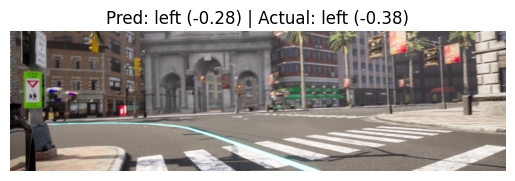

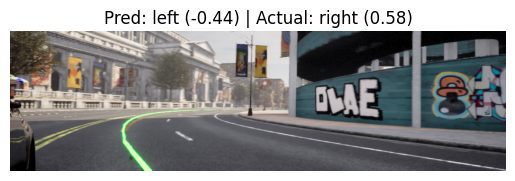

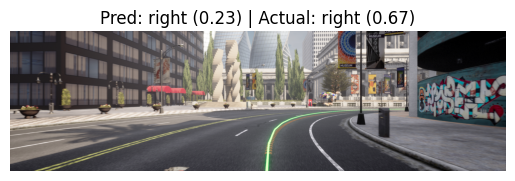

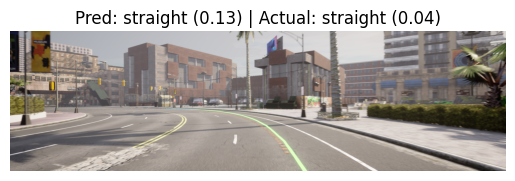

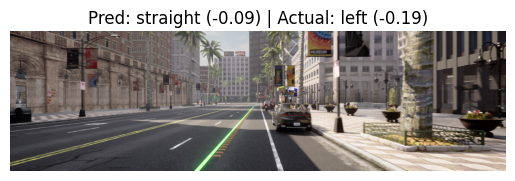

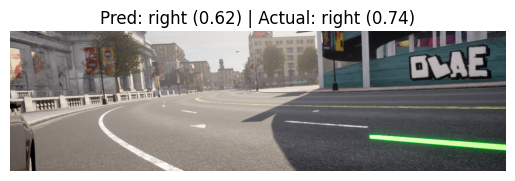

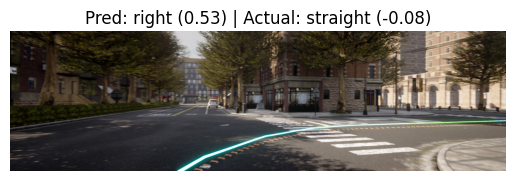

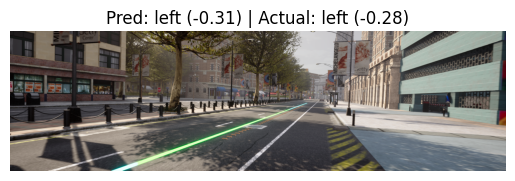

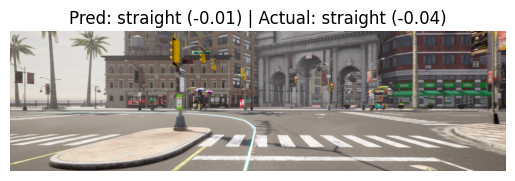

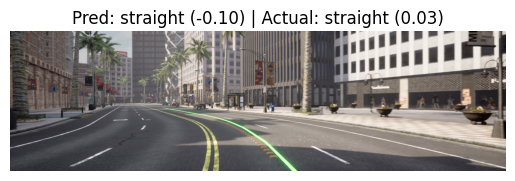

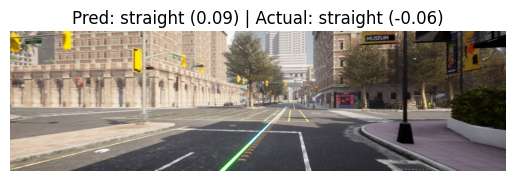

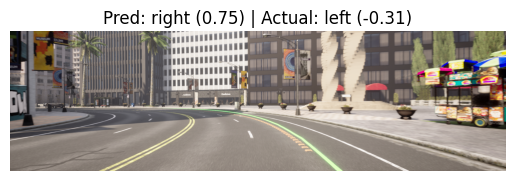

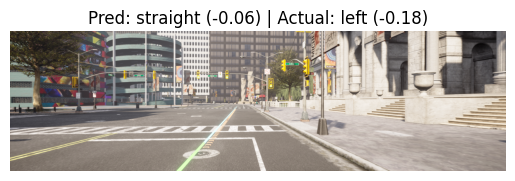

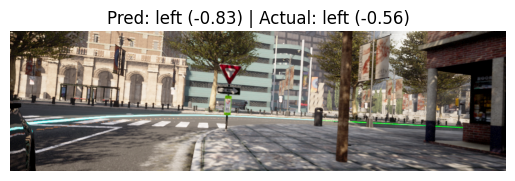

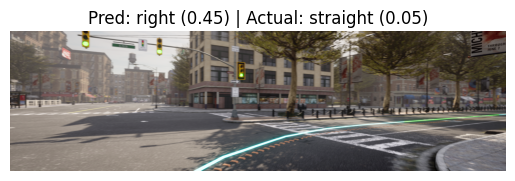

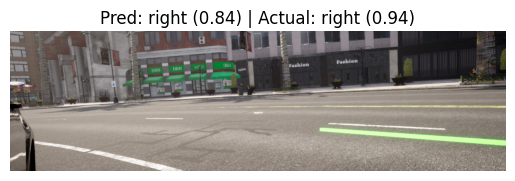

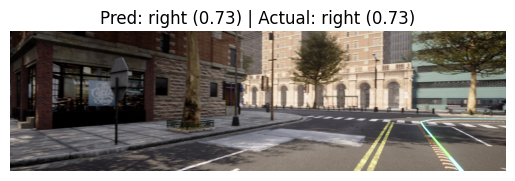

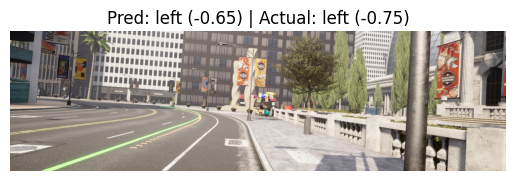

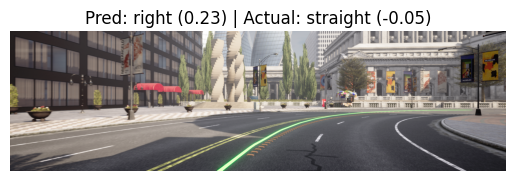

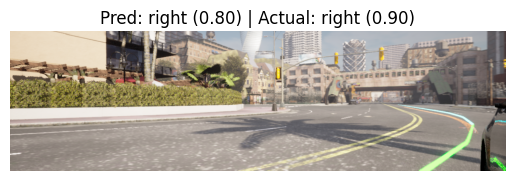


✅ Proportional Classification Accuracy (±0.15): 72.73%


<Figure size 600x500 with 0 Axes>

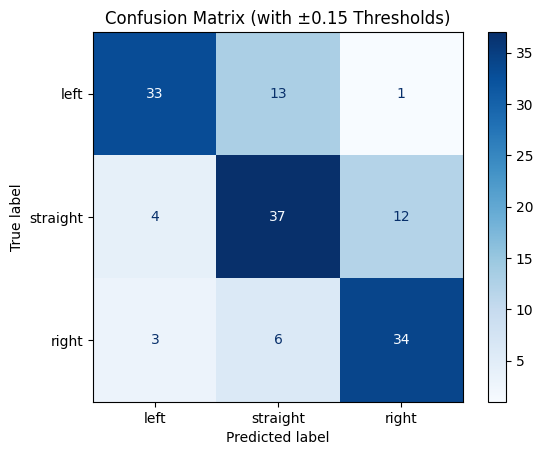

In [10]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import random
from glob import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# === PATHS ===
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\floating_labels.csv"
MODEL_FILE = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follow_model.joblib"

# === Load label CSV ===
labels_df = pd.read_csv(LABEL_CSV)
labels_df['filename'] = labels_df['filename'].str.lower()
label_dict = dict(zip(labels_df['filename'], labels_df['Maneuvering']))

# === Load model ===
model = joblib.load(MODEL_FILE)

# === HSV threshold for green line ===
LOWER_HSV = np.array([70, 50, 50])
UPPER_HSV = np.array([90, 255, 255])

# === Feature extraction ===
def extract_features(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, LOWER_HSV, UPPER_HSV)
    height, width = mask.shape

    bands = [mask[int(height * 0.6):int(height * 0.7), :],
             mask[int(height * 0.7):int(height * 0.8), :],
             mask[int(height * 0.8):, :]]

    features = []
    for band in bands:
        indices = np.column_stack(np.where(band > 0))
        if indices.size > 0:
            avg_x = np.mean(indices[:, 1]) / width * 2 - 1
        else:
            avg_x = 0.0
        features.append(avg_x)

    return features

# === Updated Bin logic with stricter thresholds ===
def label_to_bin(value):
    if value < -0.15:
        return "left"
    elif value > 0.15:
        return "right"
    else:
        return "straight"

# === Prepare data ===
data = []
image_paths = sorted(glob(os.path.join(IMAGE_FOLDER, "*.png")))

for img_path in image_paths:
    filename = os.path.basename(img_path).lower()
    if filename not in label_dict:
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    features = extract_features(image)
    label = label_dict[filename]
    data.append((features, label, filename))

# === Shuffle and split ===
random.shuffle(data)
split_index = int(len(data) * 0.8)
test_data = data[split_index:]

# === Predict and evaluate ===
y_true = []
y_pred = []
y_true_bin = []
y_pred_bin = []

print("\n📊 Predictions on 20 test samples (with stricter binning):\n")
for i, (features, true_val, fname) in enumerate(test_data):
    pred_val = model.predict([features])[0]
    true_bin = label_to_bin(true_val)
    pred_bin = label_to_bin(pred_val)

    y_true.append(true_val)
    y_pred.append(pred_val)
    y_true_bin.append(true_bin)
    y_pred_bin.append(pred_bin)

    # Display first 20 test images with their predicted and actual labels
    if i < 20:
        # Read the image for display
        img = cv2.imread(os.path.join(IMAGE_FOLDER, fname))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

        # Display the image with title
        plt.imshow(img_rgb)
        plt.title(f"Pred: {pred_bin} ({pred_val:.2f}) | Actual: {true_bin} ({true_val:.2f})")
        plt.axis('off')
        plt.show()

# === Accuracy ===
accuracy = accuracy_score(y_true_bin, y_pred_bin)
print(f"\n✅ Proportional Classification Accuracy (±0.15): {accuracy * 100:.2f}%")

# === Confusion Matrix ===
cm = confusion_matrix(y_true_bin, y_pred_bin, labels=["left", "straight", "right"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["left", "straight", "right"])
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix (with ±0.15 Thresholds)")
plt.show()
